# Segmentation d'une tumeur cérébrale en IRM
Le choix de la séquence d'une imagerie par résonance magnétique (IRM) dépend du type de tissu que l'on souhaite visualiser et des informations spécifiques que l'on cherche à obtenir. Voici quelques exemples de séquences d'IRM et leur utilisation :

- La séquence pondérée en T1 est utile pour visualiser les tissus mous et les organes. Elle fournit des images de haute résolution avec une bonne différenciation entre les tissus mous, et elle est souvent utilisée pour évaluer la structure du cerveau, du foie, des reins et de la moelle épinière.
- La séquence pondérée en T2 est utile pour visualiser les tissus qui contiennent beaucoup d'eau, tels que les liquides et les tissus mous inflammatoires. Elle fournit des images avec une bonne différenciation entre les fluides et les tissus mous, et elle est souvent utilisée pour évaluer les pathologies des articulations, des muscles, de la colonne vertébrale et des organes pelviens.
- La séquence pondérée en diffusion est utile pour évaluer la mobilité de l'eau dans les tissus. Elle peut aider à détecter les zones de tissu anormal, tels que les tumeurs, en mesurant la mobilité de l'eau dans les tissus environnants.
- La séquence pondérée en FLAIR (Fluid Attenuated Inversion Recovery) est utile pour supprimer les signaux du liquide céphalo-rachidien (LCR) afin de visualiser les tissus adjacents. Elle est souvent utilisée pour évaluer les pathologies du cerveau et de la moelle épinière.

Le but est de créer un modèle qui peut identifier et découper une tumeur ou une structure cancéreuse dans une série d'images en coupe ou slice (suivant l'axe Z) d'un patient. 

Pour construire ce modèle, nous allons utiliser le jeu de données publiques du challenge BRATS2019, qui contient des images IRM de plusieurs coupes et contrastes différents de patients atteints d'une tumeur, ainsi que des segmentations manuelles de ces tumeurs. 
Vous pourrez retrouver ces données sur le site web de Medical Image Computing and Computer Assisted Intervention (MICCAI).
Le jeu d'entrainement est disponible à partir de ce lien : https://www.med.upenn.edu/cbica/brats2019/data.html et celui de la validation est ici: https://www.med.upenn.edu/cbica/brats2019/registration.html. Les données sont fournies sous forme de fichiers zip contenant les images IRM et les segmentations pour chaque patient. A noter cependant que pour accéder à ces données, il faut d'abord s'inscrire en tant que participant au défi BRATS2019 et accepter les conditions d'utilisation.

### Description des données
BRATS2019 (Brain Tumor Segmentation Challenge) est un ensemble de données de référence pour la segmentation de la tumeur cérébrale en IRM.
Les images IRM contenues dans les dossiers HGG et LGG du jeu de données BRATS2019 comprennent les données de patients atteints de tumeurs cérébrales de grade élevé (HGG : High-Grade Gliomas) et de grade bas (LGG : Low-Grade Gliomas). Les images IRM dans ces dossiers comprennent plusieurs gammes de contrastes qui permettent de visualiser différentes propriétés des tissus cérébraux.

Chaque patient est identifié par un dossier spécifique contenant plusieurs images au format NIfTI associées aux différentes images IRM du patient.
Les images IRM comprennent les pondérations T1, T1 après retouche de contraste, T2 et FLAIR (suppression du signal provenant du liquide céphalo-rachidien) évoquées dans l'introduction.
Chaque dossier patient contient également un fichier de segmentation (_seg.nii) qui indique la localisation de la tumeur ou de la structure cancéreuse, c'est à dire les étiquettes de classe pour la tumeur active, la nécrose, l'œdème et la région non tumorale.

Les images sont acquises dans plusieurs plans d'imagerie, en particulier dans le plan axial (selon l'axe Z de la hauteur), qui permet de visualiser les coupes transversales du cerveau.

#### Imports packages

In [9]:
!pip install nibabel #package provides read write access to some common medical and neuroimaging file formats (including NIfTI1)
!pip install nilearn

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 35.5 MB/s eta 0:00:0000:0100:01


In [12]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
import shutil

import nibabel as nib
from nilearn.image import resample_img

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import KFold

In [8]:
!mkdir -p data/
shutil.unpack_archive('LGG.zip', 'data/')
shutil.unpack_archive('HGG.zip', 'data/') 
!rm LGG.zip && rm HGG.zip

In [36]:
folder_path = 'data/'
hgg_dir = os.path.join(folder_path, 'HGG')
lgg_dir = os.path.join(folder_path, 'LGG')

### Exploration des données

In [40]:
def count_patients_images():
    
    hgg_patients = os.listdir(hgg_dir)
    lgg_patients = os.listdir(lgg_dir)

    hgg_num_images = 0
    lgg_num_images = 0
    
    
    for patient in hgg_patients:
        patient_dir = os.path.join(hgg_dir, patient)
        img_files = os.listdir(patient_dir)
        hgg_num_images += len(img_files)

    for patient in lgg_patients:
        patient_dir = os.path.join(lgg_dir, patient)
        img_files = os.listdir(patient_dir)
        lgg_num_images += len(img_files)

    num_hgg_patients = len(hgg_patients)
    num_lgg_patients = len(lgg_patients)

    common_patients = set(hgg_patients) & set(lgg_patients)
    num_common_patients = len(common_patients)

    print(f"HGG contient {num_hgg_patients} patients et {hgg_num_images} images.")
    print(f"LGG contient {num_lgg_patients} patients et {lgg_num_images} images.")
    print(f"Il existe {num_common_patients} patients en commun entre HGG and LGG.")

In [41]:
count_patients_images()

HGG contient 259 patients et 1295 images.
LGG contient 76 patients et 380 images.
Il existe 0 patients en commun entre HGG and LGG.


### Redimensionnement des images 
Les images IRM cérébrales originales ont des tailles différentes en termes de largeur, de hauteur et de profondeur. Par conséquent, afin d'appliquer un modèle de réseau de neurones qui nécessite des tailles d'entrée spécifiques, les images IRM cérébrales sont redimensionnées pour avoir des dimensions cohérentes.

Pour rappel, la plus petite unité de mesure dans une image médicale en 3D, comme une IRM ou un scanner, s'appelle un Voxel (contraction de "volume" et "pixel"). On peut considérer que c'est l'équivalent tridimensionnel d'un pixel. Un voxel représente donc un petit volume de tissu dans l'organe ou la région examinée, et possède une valeur numérique qui reflète les caractéristiques physiques ou biologiques du tissu qu'il représente. Par exemple, dans une image IRM du cerveau, un voxel peut représenter un petit volume de matière grise ou blanche, de liquide céphalo-rachidien ou d'autres tissus.

In [42]:
def resize_images(data_dir=folder_path):
    dirs = [hgg_dir, lgg_dir]
            
    for directory in dirs:
        for subject in os.listdir(directory):
            subject_dir = os.path.join(directory, subject)
            flair_file = os.path.join(subject_dir, subject + '_flair.nii')
            if not os.path.exists(flair_file):
                continue
            flair_img = nib.load(flair_file)
            original_shape = flair_img.shape
            zooms = flair_img.header.get_zooms()[:3]
            affine = flair_img.affine

            # nouvelle forme et nouvelle affine
            new_shape = (240, 240, 155)
            new_affine = np.diag(zooms + (1,))

            # redimensionnement de l'image
            resampled_img = resample_img(flair_img, target_affine=new_affine, target_shape=new_shape, interpolation='nearest')

            # récupération des tranches non vides, supprime les pixels vides en utilisant les masques booléens
            non_zero_slices = np.any(resampled_img.get_fdata(), axis=(0, 1))
            if not np.any(non_zero_slices):
                continue  # si toutes les tranches sont vides, on ne fait rien
            min_slice, max_slice = np.where(non_zero_slices)[0][[0, -1]]
            
            min_row, max_row = np.where(non_zero_rows)[0][[0, -1]]
            min_col, max_col = np.where(non_zero_cols)[0][[0, -1]]
            cropped_data = resampled_data[min_slice:max_slice+1, min_row:max_row+1, min_col:max_col+1]
            
            #Dans ce code modifié, nous avons ajouté un vecteur de taille 4 (contenant une valeur 1 à la fin) à la fin de la variable zooms pour 
            #créer une matrice diagonale 4x4. Ensuite, nous avons utilisé cette matrice 4x4 comme nouvelle affine dans la fonction resample_img(). 
            #Enfin, nous avons écrasé le fichier original avec l'image redimensionnée en utilisant la fonction nib.save().
            
            # Save the resampled and cropped image
            nib.save(nib.Nifti1Image(cropped_data, new_affine), flair_file)


In [43]:
resize_images(folder_path)

### Affichage des images pour quelques (5) patients

Images pour le patient HGG BraTS19_CBICA_AAL_1
Images pour le patient HGG BraTS19_CBICA_AWI_1
Images pour le patient HGG BraTS19_CBICA_ATB_1
Images pour le patient HGG BraTS19_CBICA_BHV_1
Images pour le patient HGG BraTS19_CBICA_AME_1
Images pour le patient LGG BraTS19_TCIA12_249_1
Images pour le patient LGG BraTS19_TCIA10_109_1
Images pour le patient LGG BraTS19_TCIA10_276_1
Images pour le patient LGG BraTS19_TCIA10_130_1
Images pour le patient LGG BraTS19_TCIA10_449_1


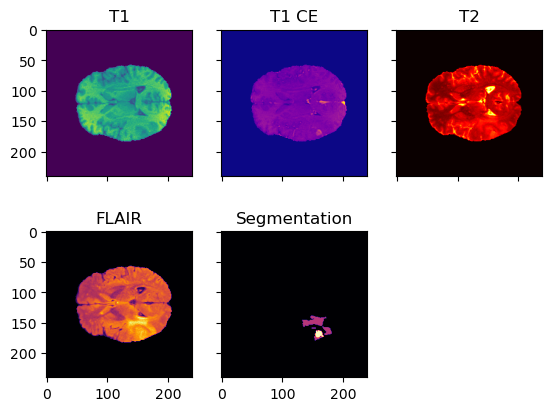

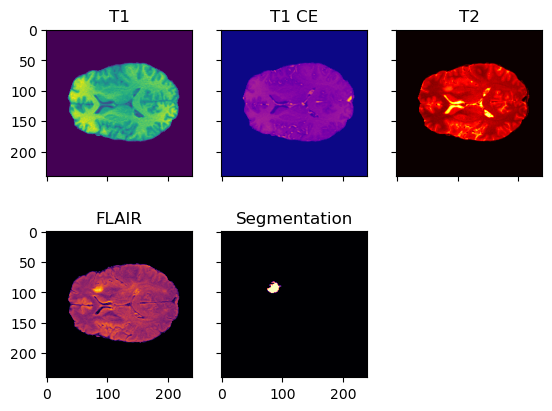

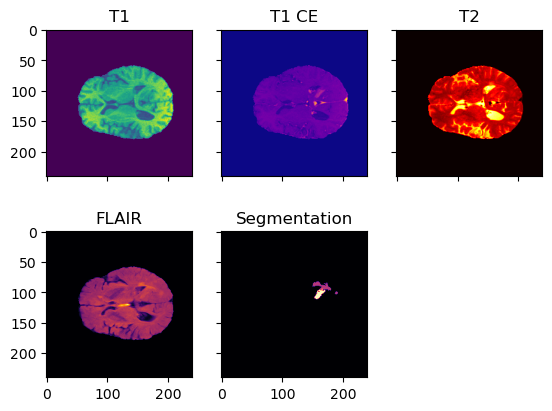

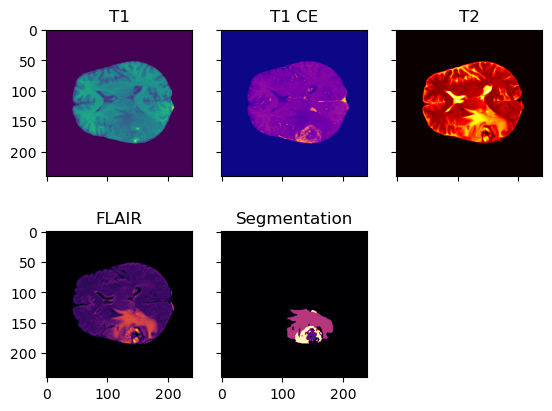

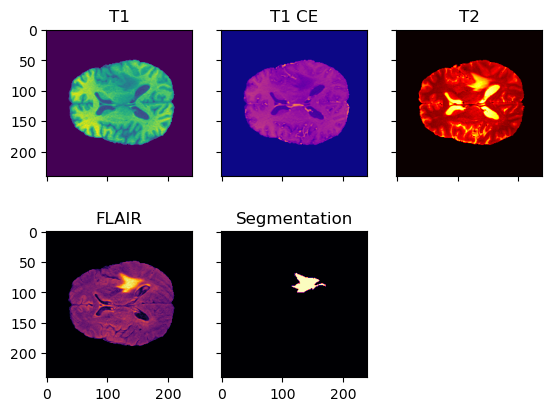

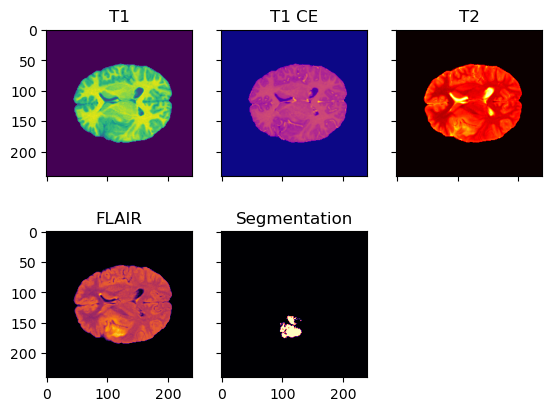

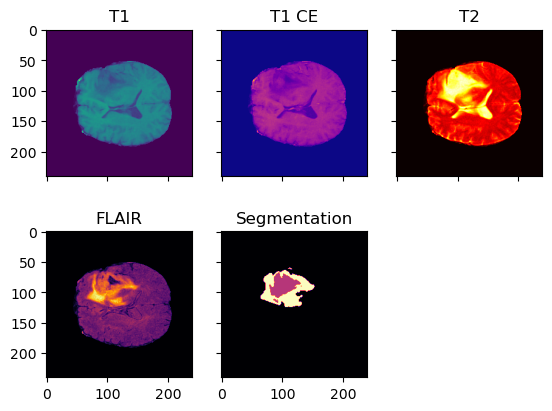

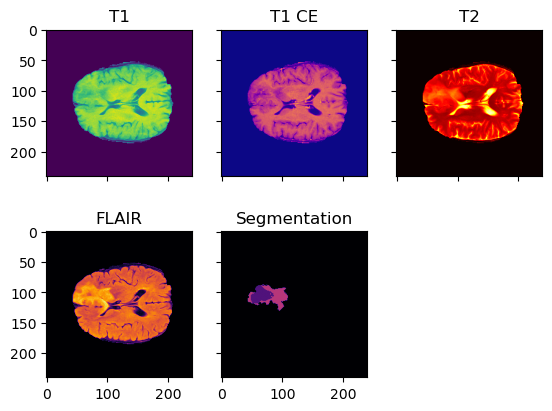

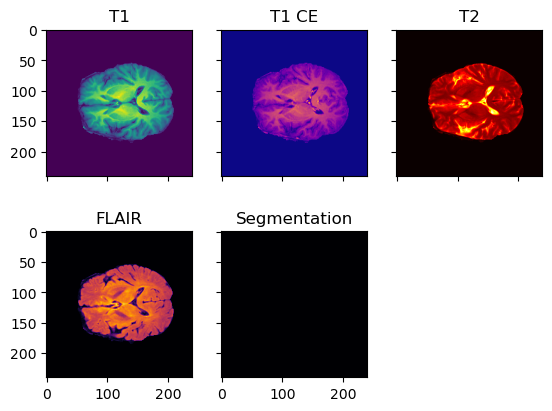

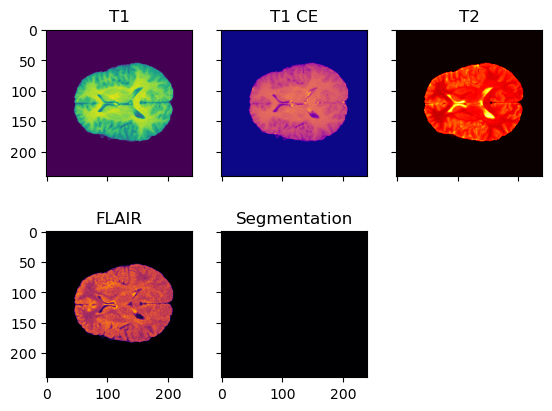

In [34]:
def display_images(patient_dir, patient):
    """
    Affiche les images IRM pour un patient donné
    """
    t1_file = os.path.join(patient_dir, str(patient)+'_t1.nii')
    t1ce_file = os.path.join(patient_dir, str(patient)+'_t1ce.nii')
    t2_file = os.path.join(patient_dir, str(patient)+'_t2.nii')
    flair_file = os.path.join(patient_dir, str(patient)+'_flair.nii')
    seg_file = os.path.join(patient_dir, str(patient)+'_seg.nii')

    t1_img = nib.load(t1_file).get_fdata()
    t1ce_img = nib.load(t1ce_file).get_fdata()
    t2_img = nib.load(t2_file).get_fdata()
    flair_img = nib.load(flair_file).get_fdata()
    seg_img = nib.load(seg_file).get_fdata()

    fig, axs = plt.subplots(2, 3)
    axs[0, 0].imshow(t1_img[:, :, t1_img.shape[2]//2], cmap='viridis')
    axs[0, 0].set_title('T1')
    axs[0, 1].imshow(t1ce_img[:, :, t1ce_img.shape[2]//2], cmap='plasma')
    axs[0, 1].set_title('T1 CE')
    axs[0, 2].imshow(t2_img[:, :, t2_img.shape[2]//2], cmap='hot')
    axs[0, 2].set_title('T2')
    axs[1, 0].imshow(flair_img[:, :, flair_img.shape[2]//2], cmap='inferno')
    axs[1, 0].set_title('FLAIR')
    axs[1, 1].imshow(seg_img[:, :, seg_img.shape[2]//2], cmap='magma')
    axs[1, 1].set_title('Segmentation')
    axs[1, 2].axis('off') # Supprimer les axes et la bordure de la dernière image


    for ax in axs.flat:
        ax.label_outer()

def display_patient_images(data_dir=folder_path, num_patients=5):
    """
    Affiche les images IRM pour les patients HGG et LGG
    """
    hgg_dir = os.path.join(data_dir, 'HGG')
    lgg_dir = os.path.join(data_dir, 'LGG')
    
    hgg_patients = os.listdir(hgg_dir)[:num_patients]
    lgg_patients = os.listdir(lgg_dir)[:num_patients]

    for patient in hgg_patients:
        patient_dir = os.path.join(hgg_dir, patient)
        print(f"Images pour le patient HGG {patient}")
        display_images(patient_dir, patient)

    for patient in lgg_patients:
        patient_dir = os.path.join(lgg_dir, patient)
        print(f"Images pour le patient LGG {patient}")
        display_images(patient_dir, patient)

display_patient_images(folder_path, 5)

In [ ]:
def k_fold_split(flair_files, seg_files, k=5, shuffle=True):
    """
    Diviser les images FLAIR et de segmentation en k folds pour la validation croisée
    
    Arguments:
    - flair_files : liste des chemins des fichiers images FLAIR
    - seg_files : liste des chemins des fichiers images de segmentation
    - k : nombre de folds (par défaut : 5)
    - shuffle : mélanger les données avant de diviser (par défaut : True)
    
    Retourne:
    - folds : liste de k tuples contenant les index des images de chaque fold pour l'entraînement et la validation
    """
    # Mélanger les indices des images si shuffle=True
    indices = list(range(len(flair_files)))
    if shuffle:
        np.random.shuffle(indices)
    
    # Diviser les indices en k folds
    kf = KFold(n_splits=k)
    folds = []
    for train_index, val_index in kf.split(indices):
        train_flair = [flair_files[i] for i in train_index]
        train_seg = [seg_files[i] for i in train_index]
        val_flair = [flair_files[i] for i in val_index]
        val_seg = [seg_files[i] for i in val_index]
        folds.append((train_flair, train_seg, val_flair, val_seg))
    return folds

### Construction d'un modèle UNET
U-Net est un modèle de réseau de neurones convolutifs largement utilisé pour la segmentation d'images médicales, y compris pour la segmentation des tumeurs. La structure en forme de U de U-Net permet de combiner des informations contextuelles globales avec des informations locales précises afin de réaliser des segmentations précises des régions d'intérêt dans les images médicales. En particulier, U-Net est connu pour être performant dans la segmentation de structures anatomiques complexes, telles que les tumeurs, dans les images médicales en 3D.

In [44]:
def build_unet(flair_folder, seg_folder, epochs=10, batch_size=32, learning_rate=1e-4, input_size=(240, 240)):
    """
    Construire et entraîner un U-Net sur les images FLAIR à l'aide des segmentations de brats2019 contenues dans HGG et LGG
    
    Arguments:
    - flair_folder : chemin vers le dossier contenant les images FLAIR
    - seg_folder : chemin vers le dossier contenant les images de segmentation
    - epochs : nombre d'epochs pour l'entraînement (par défaut : 10)
    - batch_size : taille des batchs pour l'entraînement (par défaut : 32)
    - learning_rate : taux d'apprentissage pour l'optimiseur Adam (par défaut : 1e-4)
    - input_size : taille de l'entrée du réseau (par défaut : (240, 240))
    
    Retourne:
    - model : modèle U-Net entraîné
    """
    
    # Charger les images FLAIR et de segmentation
    flair_files = sorted([os.path.join(flair_folder, file) for file in os.listdir(flair_folder)])
    seg_files = sorted([os.path.join(seg_folder, file) for file in os.listdir(seg_folder)])
    flair_data = np.array([nib.load(flair_file).get_fdata() for flair_file in flair_files])
    seg_data = np.array([nib.load(seg_file).get_fdata() for seg_file in seg_files])
    
    # Normaliser les images FLAIR
    flair_data = (flair_data - np.mean(flair_data)) / np.std(flair_data)
    
    # Créer le modèle U-Net
    inputs = Input(input_size + (1,))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3,3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    # Compiler le modèle avec l'optimiseur Adam et la métrique de Dice coefficient
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=[dice_coef])

    # Entraîner le modèle sur les données FLAIR et de segmentation
    model.fit(flair_data, seg_data, epochs=epochs, batch_size=batch_size)

    return model

In [45]:
def evaluation_unet(model, flair_folder, seg_folder, input_size=(240, 240)):
    """
    Calculer la précision et la sensibilité moyenne pour un modèle U-Net sur l'ensemble de validation
    
    Arguments :
    - model : modèle U-Net entraîné
    - flair_folder : chemin vers le dossier contenant les images FLAIR de l'ensemble de validation
    - seg_folder : chemin vers le dossier contenant les images de segmentation de l'ensemble de validation
    - input_size : taille de l'entrée du réseau (par défaut : (240, 240))
    
    Retourne :
    - precision : précision moyenne sur l'ensemble de validation
    - sensibilite : sensibilité moyenne sur l'ensemble de validation
    """
    # Charger les images FLAIR et de segmentation de l'ensemble de validation
    flair_files = sorted([os.path.join(flair_folder, file) for file in os.listdir(flair_folder)])
    seg_files = sorted([os.path.join(seg_folder, file) for file in os.listdir(seg_folder)])
    flair_data = np.array([nib.load(flair_file).get_fdata() for flair_file in flair_files])
    seg_data = np.array([nib.load(seg_file).get_fdata() for seg_file in seg_files])
    
    # Normaliser les images FLAIR
    flair_data = (flair_data - np.mean(flair_data)) / np.std(flair_data)
    
    # Prédire la segmentation pour chaque image de l'ensemble de validation
    pred_seg_data = model.predict(flair_data[..., np.newaxis])
    
    # Calculer la précision et la sensibilité pour chaque image
    precision_scores = []
    sensibilite_scores = []
    for i in range(len(pred_seg_data)):
        true_seg = seg_data[i]
        pred_seg = np.round(pred_seg_data[i, ..., 0])
        precision_scores.append(precision_score(true_seg.flatten(), pred_seg.flatten()))
        sensibilite_scores.append(recall_score(true_seg.flatten(), pred_seg.flatten()))
    
    # Calculer la précision et la sensibilité moyenne sur l'ensemble de validation
    precision = np.mean(precision_scores)
    sensibilite = np.mean(sensibilite_scores)
    
    return precision, sensibilite

Le modèle U-Net présenté est un modèle de base pour la segmentation sémantique d'images médicales, et peut être utilisé pour des images BRATS2019 de taille (240, 240, 155) si les images sont pré-traitées et normalisées correctement.
Cependant, il est important de noter que ce modèle de base peut ne pas être suffisant pour obtenir des performances de segmentation précises sur les données BRATS2019, qui sont connues pour être très complexes en raison de la grande variabilité anatomique et pathologique des tumeurs cérébrales.
Il est donc recommandé de tester plusieurs architectures de modèles et d'expérimenter avec différents paramètres d'entraînement pour trouver la meilleure configuration pour ce jeu de données spécifique.